# Изучение закономерностей, определяющих успешность игр

Данное исследование предназначено для планирования кампании продаж компьютерных игр на 2017 год. Для её успеха необходимо выявить закономерности, определяющие успешность продажи игры. В нашем распоряжении находятся данные по продажам игр до 2016 года включительно, по ним можно узнать такие параметры как: платформа игры, дата выхода, количество проданных копий в разных регионах, оценки критиков и игроков, возрастной рейтинг. В ходе исследования будет проведена предобработка данных, анализ сведений за актуальный период, будет составлен портрет типичного пользователя в каждом регионе.

### Загружаем данные и изучаем общую информацию

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from scipy import stats as st
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv('games.csv')

In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Подготавливаем данные

In [6]:
data.columns = data.columns.str.lower()

In [7]:
null_rows = data.isna().sum() 
null_rows = null_rows[null_rows != 0]
print(null_rows)

name                  2
year_of_release     269
genre                 2
critic_score       8578
user_score         6701
rating             6766
dtype: int64


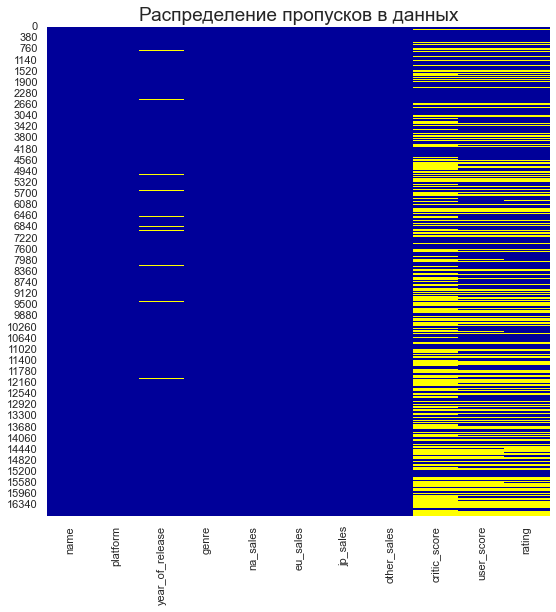

In [8]:
sns.set(rc={'figure.figsize':(9, 9)})
colours = ['#000099', '#ffff00'] 
(sns.heatmap(data.isnull(), cmap=sns.color_palette(colours), cbar=False)
    .set_title('Распределение пропусков в данных', fontsize=19));

<b>Удалим значения без названия игры:

In [9]:
data = data.dropna(subset=['name'])

<b> В названии игры может встречаться год. Скорее всего, это будет выхода, ±1. Найдем такие игры и заменим пропуски:

In [10]:
all_years = data.year_of_release.unique()

def year_in_name(row):
    
    name = row['name']
    year = row['year_of_release']
    
    if math.isnan(year):
        
            li = list(np.float_(re.findall('[0-9]+', name)))
            
            for a in all_years:
                if a in li:
                    print(name)
                    return a
                else:
                    continue
    else:
        return year
    
data['year_of_release'] = data.apply(year_in_name, axis = 1)

Madden NFL 2004
FIFA Soccer 2004
wwe Smackdown vs. Raw 2006
NASCAR Thunder 2003
PES 2009: Pro Evolution Soccer
Madden NFL 2002
NFL GameDay 2003
NBA Live 2003
Tomb Raider (2013)
All-Star Baseball 2005
NBA Live 2003
All-Star Baseball 2005
Tour de France 2011
Sega Rally 2006
PDC World Championship Darts 2008
Football Manager 2007
PDC World Championship Darts 2008


In [11]:
data.year_of_release.isna().sum() 

252

<b>Заполнили 17 ячеек. Остальные пустые значения удалим, т.к. дальше по заданию нам будет необходимо определить актуальный период, и игры без года выпуска туда всё равно не попадут.

In [12]:
data = data.dropna(subset=['year_of_release'])

<b>'tbd' означает To Be Determined (будет определено). Не будем ждать, пока вынесут оценку, ведь уже декабрь, просто заменим тип данных:

In [13]:
data = data.replace({'user_score':{'tbd':float('nan')}})

In [14]:
data.year_of_release = pd.to_numeric(data.year_of_release, downcast='integer')
data.user_score = pd.to_numeric(data.user_score, downcast='float', errors ='coerce')

In [15]:
data.rating.fillna('no_rating');
data.rating = data.rating.replace({float('nan'): 'no_rating'})
data.rating.unique()

array(['E', 'no_rating', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

<b>Удалим аномальные значения в столбцах с оценкой и приведем их к одинаковому виду:

In [16]:
data['critic_score'] = data['critic_score'] / 10

<b>Если есть пропуск в одном из столбцах с оценкой, можно заменить соседним значением, допуская, что значения примерно равны (если это значение есть):

In [17]:
def critic_to_user(row):
    critic_score = row.critic_score
    user_score = row.user_score
    if math.isnan(critic_score):
        return user_score
    else:
        return critic_score
    
def user_to_critic(row):
    critic_score = row.critic_score
    user_score = row.user_score
    if math.isnan(user_score):
        return critic_score
    else:
        return user_score
    
data['user_score'] = data.apply(user_to_critic, axis = 1)
data['critic_score'] = data.apply(critic_to_user, axis = 1)
#я проверил, такая замена не влияет на дальнейшие результаты

<b>Проверим полные дубликаты:

In [18]:
data.duplicated().sum()

0

<b>Добавляем столбец с общими продажами:

In [19]:
data['all_sales'] = data['eu_sales'] + data['jp_sales'] + data['na_sales'] + data['other_sales']

### Исследовательский анализ данных

<b>Посмотрим, сколько игр выпускалось в разные годы. 

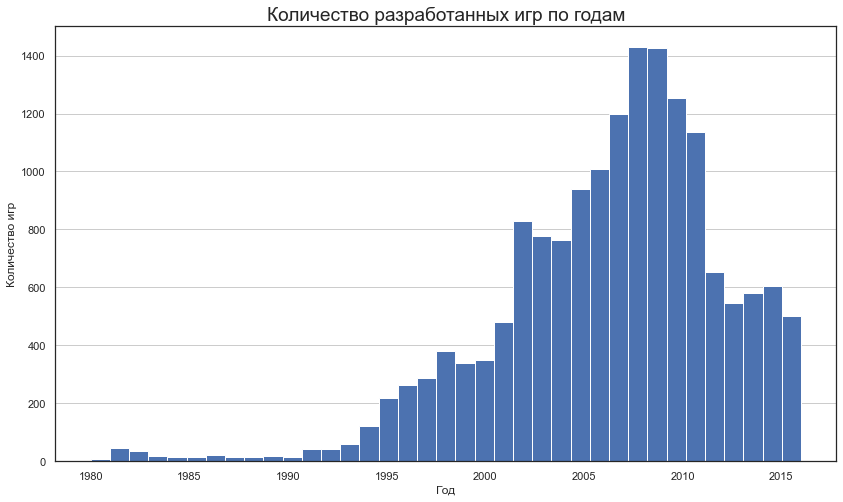

2016     502
2015     606
2014     581
2013     545
2012     653
2011    1137
2010    1255
2009    1427
2008    1429
2007    1198
Name: year_of_release, dtype: int64

In [20]:
sns.set(style='white')
plt.figure(figsize=(14, 8))

plt.hist(data.year_of_release, 
         bins=37)


plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.title('Количество разработанных игр по годам', fontsize=19)
plt.grid(axis = 'y')
plt.show()

(data['year_of_release'].value_counts()
                        .sort_index(ascending=False)
                        .head(10)
)

<b> Брать данные за весь период не имеет смысла, так как эта индустрия постоянно меняется. Из графика видно, что за последние 5 лет количество выпускаемых игр стало ощутимо меньше. "Переломным" стал 2011 год.

<b>Найдем самые прибыльные платформы за весь период:

In [21]:
platforms_dict = {}

for plat in data.platform.unique():

    sales = pd.pivot_table(data.query('platform==@plat'), index='year_of_release', values='all_sales', 
               aggfunc=np.sum)

    platforms_dict[plat] = sales
    platforms_dict[plat] = platforms_dict[plat].rename(columns={'all_sales':plat})

result_sales = []
result_sales = pd.DataFrame(result_sales)

for key in platforms_dict:
    result_sales = pd.concat([result_sales, platforms_dict[key]],  axis=1)

In [22]:
result_sales.head()

,Wii,NES,GB,DS,X360,PS3,PS2,SNES,GBA,PS4,...,DC,PSV,SAT,SCD,WS,NG,TG16,3DO,GG,PCFX
year_of_release,,,,,,,,,,,,,,,,,,,,,
2006,137.15,NaN,NaN,119.81,51.62,20.96,106.46,NaN,5.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,152.77,NaN,NaN,146.94,95.42,73.19,75.99,NaN,3.40,NaN,...,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,171.32,NaN,NaN,145.32,135.26,118.52,53.90,NaN,NaN,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,206.97,NaN,NaN,119.54,120.29,130.93,26.40,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,127.95,NaN,NaN,85.02,170.03,142.17,5.64,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


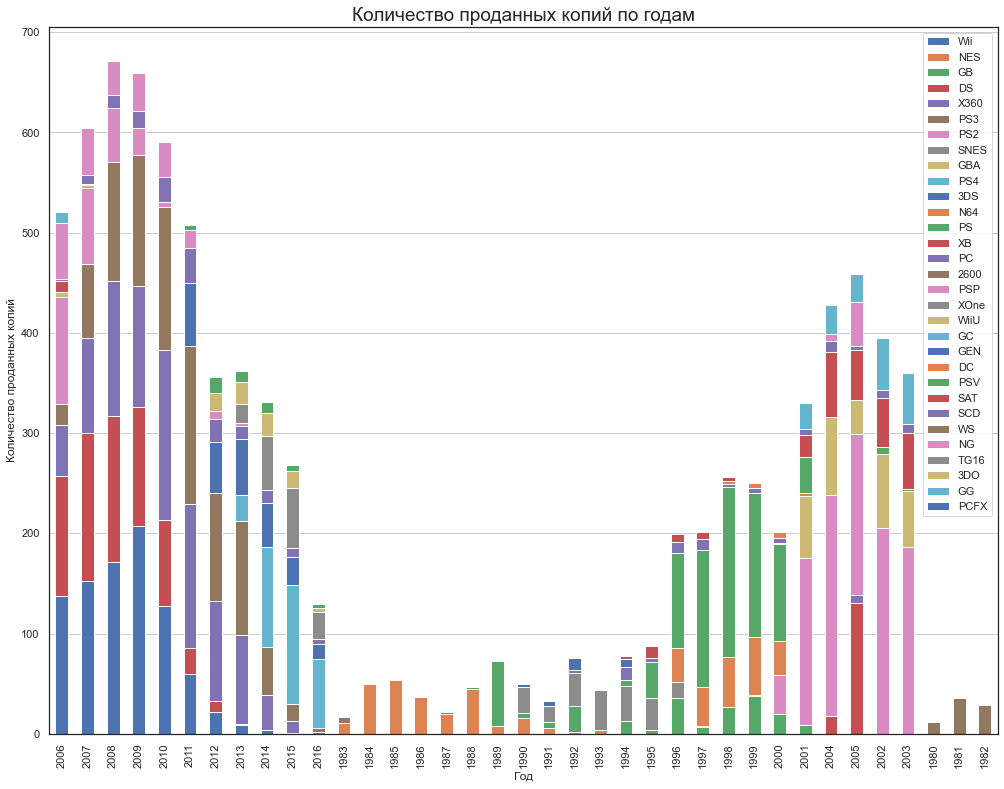

In [23]:
sns.set(style='white')

result_sales.plot(kind='bar', stacked= True, figsize=(17,13))
plt.xlabel('Год')
plt.ylabel('Количество проданных копий')
plt.title('Количество проданных копий по годам', fontsize=19)
plt.grid(axis = 'y')
plt.show()

<b>Из графика видим, что среднее "время жизни" платформы составляет 5-7 лет. Отдельно сделаем график проданный копий по годам:

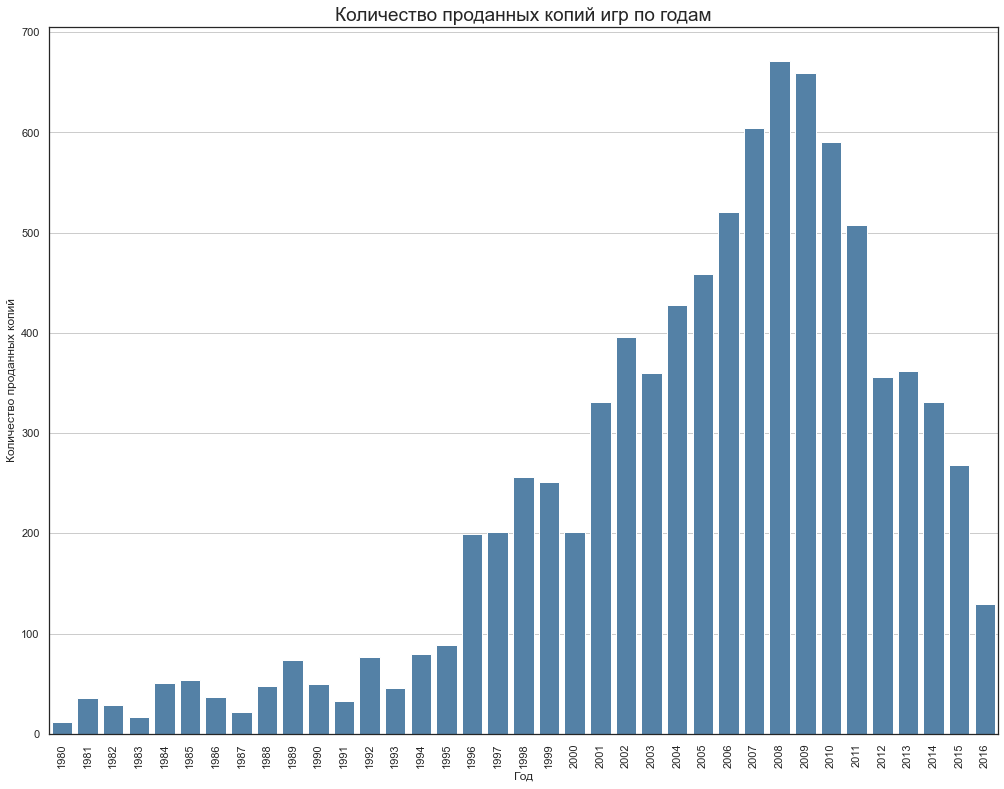

In [24]:
sales_count = pd.pivot_table(data, values='all_sales', index='year_of_release', aggfunc=np.sum)
sales_count.reset_index(level = ['year_of_release'])
sales_count = sales_count.rename_axis('year').reset_index()

plt.figure(figsize=(17, 13))

ax = sns.barplot(data=sales_count, x= 'year', y = 'all_sales', color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

plt.xlabel('Год')
plt.ylabel('Количество проданных копий')
plt.title('Количество проданных копий игр по годам', fontsize=19)
plt.grid(axis = 'y')
plt.show()

<b>В 2016 явно произошел кризис на рынке. Количество продаж с каждым годом падает. Актуальный период с учетом выявленной инфорации обозначим за 5 лет.

In [25]:
actual_data = data.query('year_of_release > 2011')

<b>Рассмотрим внимательнее продажи платформ за этот период:

In [26]:
top_platforms_2016 = actual_data.platform.unique()

top_platforms_dict = {}

for plat in top_platforms_2016:
    platform_data = actual_data.query('platform == @plat')
    platform_data  = pd.pivot_table(platform_data, index='year_of_release', values='all_sales', aggfunc=np.sum)
    platform_data.reset_index(level = ['year_of_release'])
    platform_data = platform_data.rename_axis('year').reset_index()
    platform_data.year = platform_data.year.astype(int)
    top_platforms_dict[plat] = platform_data

top_platforms_dict

{'PS3':    year  all_sales
 0  2012     107.36
 1  2013     113.25
 2  2014      47.76
 3  2015      16.82
 4  2016       3.60,
 'X360':    year  all_sales
 0  2012      99.74
 1  2013      88.58
 2  2014      34.74
 3  2015      11.96
 4  2016       1.52,
 'PS4':    year  all_sales
 0  2013      25.99
 1  2014     100.00
 2  2015     118.90
 3  2016      69.25,
 '3DS':    year  all_sales
 0  2012      51.36
 1  2013      56.57
 2  2014      43.76
 3  2015      27.78
 4  2016      15.14,
 'DS':    year  all_sales
 0  2012      11.01
 1  2013       1.54,
 'XOne':    year  all_sales
 0  2013      18.96
 1  2014      54.07
 2  2015      60.14
 3  2016      26.15,
 'WiiU':    year  all_sales
 0  2012      17.56
 1  2013      21.65
 2  2014      22.03
 3  2015      16.35
 4  2016       4.60,
 'Wii':    year  all_sales
 0  2012      21.71
 1  2013       8.59
 2  2014       3.75
 3  2015       1.14
 4  2016       0.18,
 'PC':    year  all_sales
 0  2012      23.22
 1  2013      12.73
 2  2014

<b>Удалим безнадежно устаревшие платформы (игры на которые в 2016 году не продавались):

In [27]:
[top_platforms_dict.pop(key) for key in ['Wii','X360', 'DS', 'PSP']];
actual_data = actual_data.query('platform != "Wii" and platform != "X360" \
                                and platform != "DS" and platform != "PSP"')

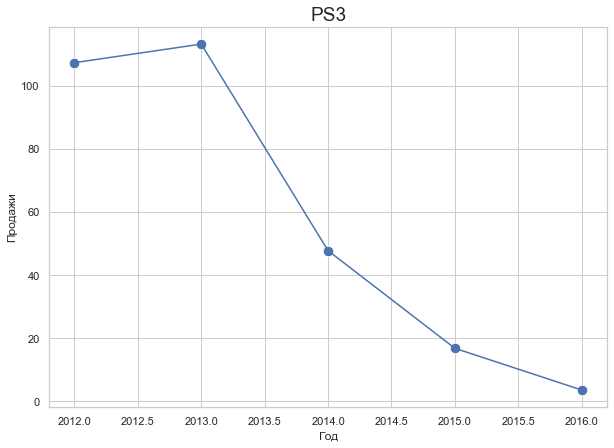

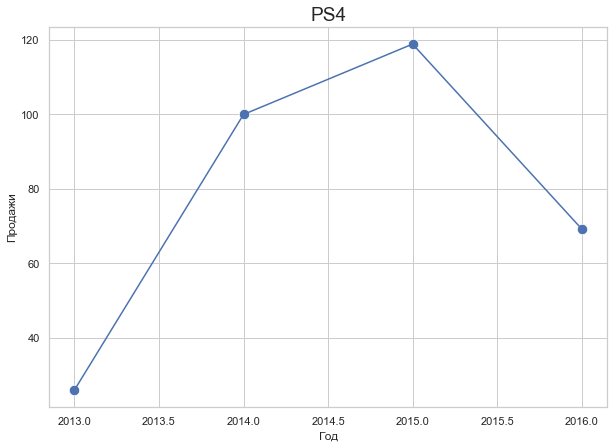

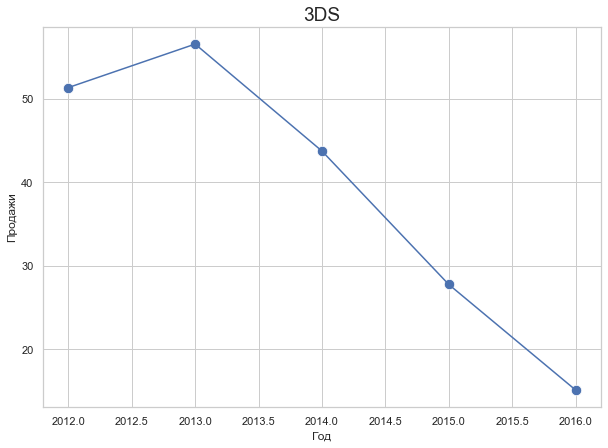

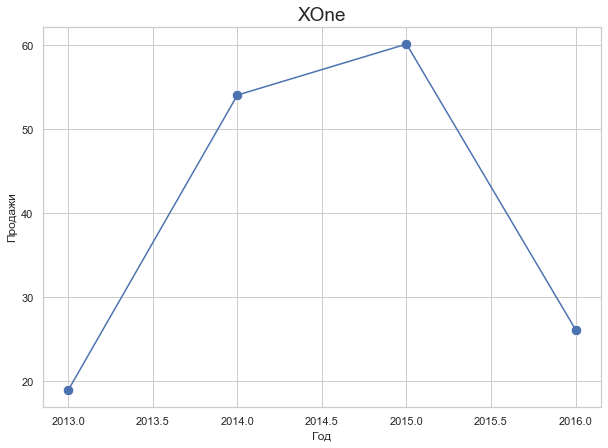

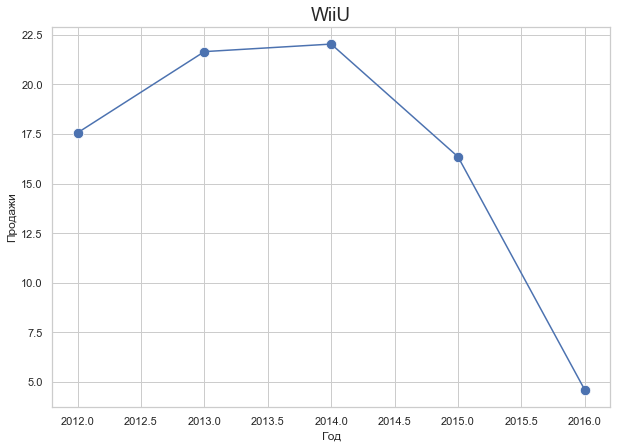

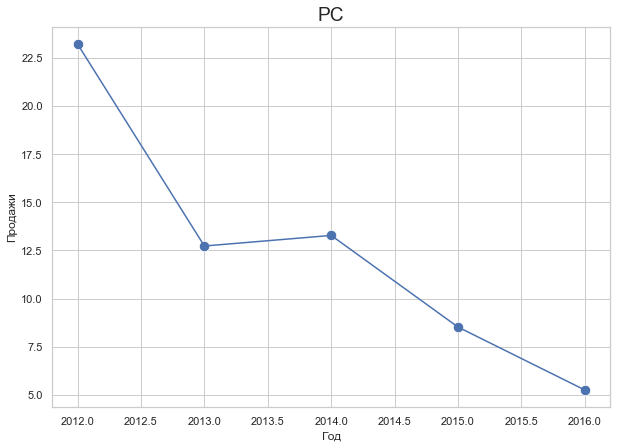

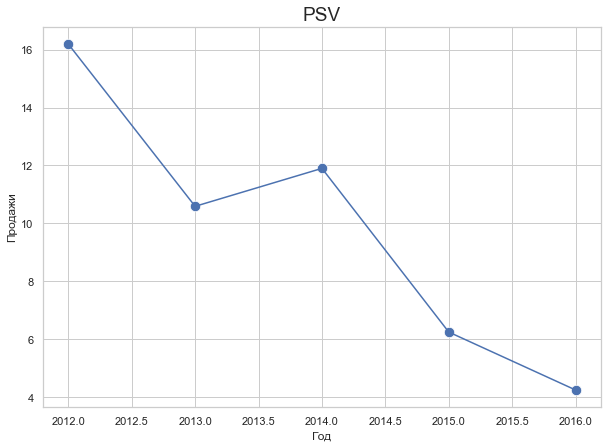

In [28]:
sns.set(style="whitegrid")  

for key in top_platforms_dict:
    
    data_l = top_platforms_dict[key]
    
    fig, ax = plt.subplots(figsize = (10,7))
    sns.scatterplot(data=data_l, x="year", y='all_sales', s=110,)
    plt.gca().set(xlabel='Год', 
                  ylabel='Продажи')
    
 
    sns.lineplot(data=data_l, x="year", y='all_sales')
    plt.gca().set(xlabel='Год', 
                  ylabel='Продажи')  
    plt.title(key, fontsize=19)

<b>Здесь тоже всё довольно пессемистично. На всех платформах продажи падают. Однако есть те, которые еще держатся на плаву - это PC, XOne, PS4, WiiU. От остальных платформ больших продаж можно не ожидать (если они вообще будут).

<b>Построим боксплоты:

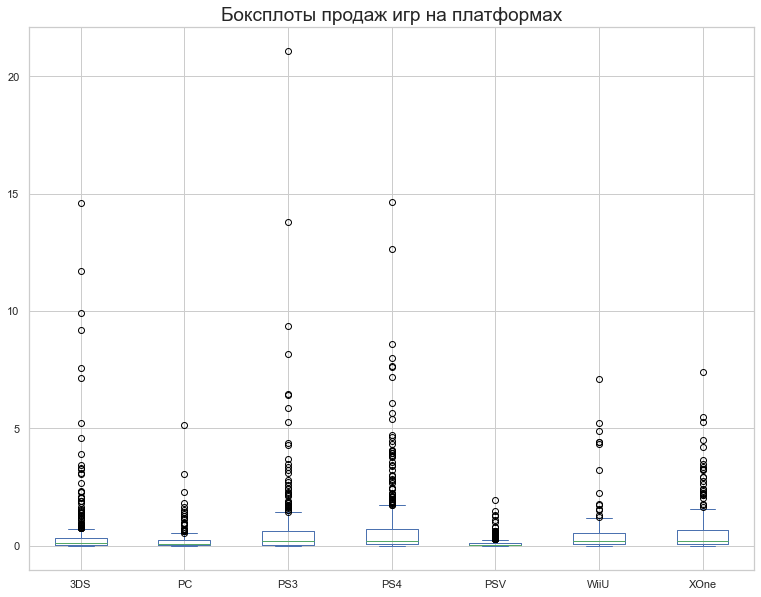

In [29]:
sns.set(style="whitegrid")  

(actual_data.pivot_table(index = 'name', columns = 'platform', 
                         values = 'all_sales', aggfunc = 'sum')
 .plot(kind='box', figsize=(13,10)))
plt.title('Боксплоты продаж игр на платформах', fontsize=19)
plt.show()

<b> Из графика видно, что на PS3, PS4 и X360 встречаются игры, которые продаются больше чем в 10 млн копий и не один год. Если в следующем году аннонсированы эксклюзивы для этих платформ, скорее всего, они тоже станут бестселлерами.

<b> Проверим, как влияет на продажи игр на PS4 отзывы пользователей и критиков. Построим диаграмму рассеяния:

In [30]:
PS4_data = actual_data.query('platform == "PS4"')
PS4_data = PS4_data[['all_sales', 'user_score', 'critic_score']]

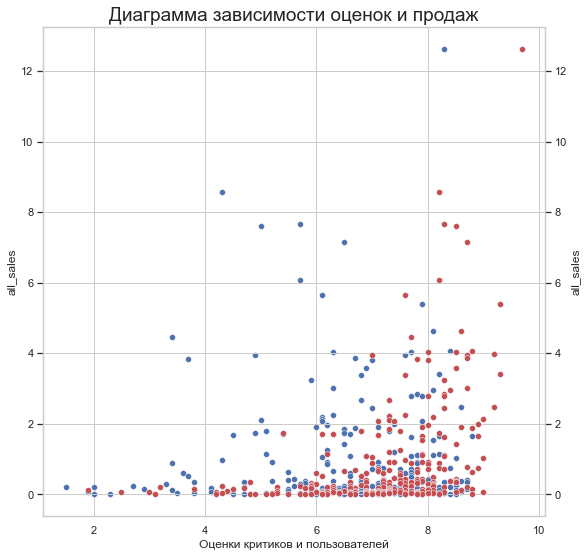

In [31]:
sns.set(style="whitegrid")  

fig, ax = plt.subplots()

sns.scatterplot(x='user_score', y='all_sales', data=PS4_data, ax=ax)

ax2 = ax.twinx()
sns.scatterplot(x='critic_score', y='all_sales', data=PS4_data, ax=ax2, color='r')
plt.title('Диаграмма зависимости оценок и продаж', fontsize=19)
ax.set(xlabel='Оценки критиков и пользователей')
plt.show()

<b>Из графика видно, что для топ-игр критики ставят оценку выше, чем пользователи . Рассчитаем корреляцию:

In [32]:
PS4_data.corr().round(2)

,all_sales,user_score,critic_score
all_sales,1.00,-0.03,0.40
user_score,-0.03,1.00,0.57
critic_score,0.40,0.57,1.00


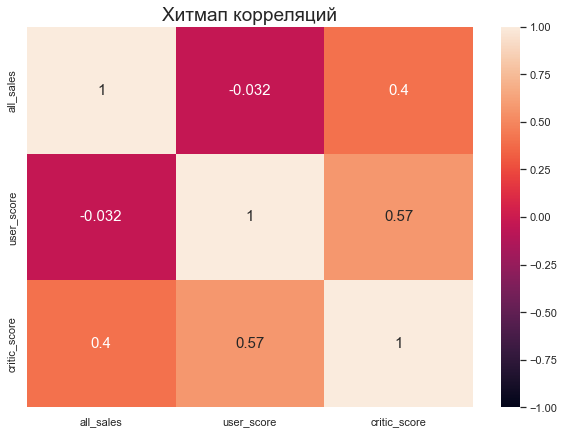

In [33]:
sns.set(rc = {'figure.figsize':(10,7)})
(sns.heatmap(PS4_data.corr(), 
            annot = True, fmt='.2g', 
            vmin=-1, vmax=+1,
            annot_kws={'fontsize':15})
    .set_title('Хитмап корреляций', fontsize=19))
plt.show()

<b>Отзывы критиков слабо, но влияют на продажи игр на PS4. Мнение игроков не влияет вообще, что странно. Проверим корреляцию на играх среднего качества и выше:

In [34]:
PS4_data = PS4_data.query('all_sales > 0.5 and user_score > 6')

In [35]:
PS4_data.corr().round(2)

,all_sales,user_score,critic_score
all_sales,1.00,0.12,0.47
user_score,0.12,1.00,0.45
critic_score,0.47,0.45,1.00


<b>Та же картина. Сравним результаты с другими актуальными платформами:

In [36]:
score_platforms_dict = {}

score_platforms = list(top_platforms_dict.keys())
score_platforms.remove('PS4')

for plat in score_platforms:
    score_data = actual_data.query('platform == @plat')
    score_data = score_data[['all_sales', 'user_score', 'critic_score']]

    print("Платформа: %s".center(40) % plat)
    display(score_data.corr())
    print('\n')

             Платформа: PS3              


,all_sales,user_score,critic_score
all_sales,1.000000,-0.002358,0.239069
user_score,-0.002358,1.000000,0.726658
critic_score,0.239069,0.726658,1.000000




             Платформа: 3DS              


,all_sales,user_score,critic_score
all_sales,1.000000,0.208947,0.287782
user_score,0.208947,1.000000,0.816797
critic_score,0.287782,0.816797,1.000000




             Платформа: XOne              


,all_sales,user_score,critic_score
all_sales,1.000000,-0.063838,0.407171
user_score,-0.063838,1.000000,0.551951
critic_score,0.407171,0.551951,1.000000




             Платформа: WiiU              


,all_sales,user_score,critic_score
all_sales,1.000000,0.397402,0.362938
user_score,0.397402,1.000000,0.811874
critic_score,0.362938,0.811874,1.000000




             Платформа: PC              


,all_sales,user_score,critic_score
all_sales,1.000000,-0.120980,0.238077
user_score,-0.120980,1.000000,0.485458
critic_score,0.238077,0.485458,1.000000




             Платформа: PSV              


,all_sales,user_score,critic_score
all_sales,1.000000,-0.003226,0.027320
user_score,-0.003226,1.000000,0.854191
critic_score,0.027320,0.854191,1.000000


<b>Для остальных платформ ситуация та же, хотя в большинстве случаев отзывы критиков действительно влияют на продажи больше отзывов игроков.

<b>Теперь рассмотрим жанры и выберем из них самые прибыльные. 

In [37]:
genre_sales = pd.pivot_table(actual_data, index='genre',
                             values='all_sales', aggfunc=['sum','count', 'median'])

genre_sales.reset_index(level = ['genre'])
genre_sales = genre_sales.rename_axis('genre').reset_index()
genre_sales.columns=['genre', 'all_sales', 'count', 'median']

genre_sales.sort_values(by='all_sales', ascending=False)

,genre,all_sales,count,median
0,Action,343.54,831,0.120
8,Shooter,232.03,186,0.435
7,Role-Playing,170.05,323,0.150
10,Sports,141.05,205,0.240
4,Platform,55.92,75,0.240
3,Misc,51.46,151,0.110
6,Racing,45.08,93,0.130
2,Fighting,39.16,89,0.130
9,Simulation,33.10,68,0.115
1,Adventure,24.24,229,0.030


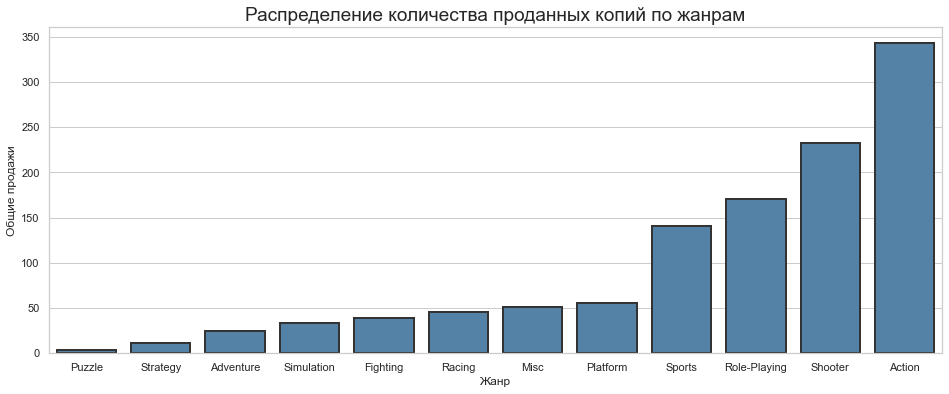

In [38]:
sns.set(style="whitegrid")  

plt.figure(figsize=(16, 6))

sns.barplot(data=genre_sales, x= 'genre', y = 'all_sales',
            order=genre_sales.sort_values('all_sales').genre,
            linewidth=2, edgecolor=".2", color='steelblue')

plt.gca().set(xlabel='Жанр', 
              ylabel='Общие продажи')

plt.title('Распределение количества проданных копий по жанрам', fontsize=19)
plt.show()

<b>Самые продаваемые жанры - экшен и шутеры. Дальше идет пара - спортивные игры и РПГ, отстальные жанры продаются меньше 50 млн. копий. Но количество выпускаемых игр в каждом жанре различается, поэтому подсчитаем медианное значение:

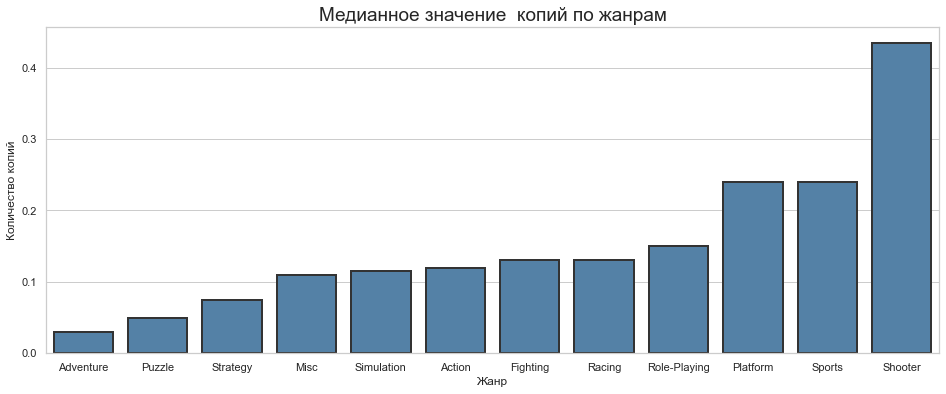

In [39]:
sns.set(style="whitegrid")  

plt.figure(figsize=(16, 6))

sns.barplot(data=genre_sales, x= 'genre', y = 'median',
            order=genre_sales.sort_values('median').genre,
            linewidth=2, edgecolor=".2", color='steelblue')

plt.gca().set(xlabel='Жанр', 
              ylabel='Количество копий')

plt.title('Медианное значение  копий по жанрам', fontsize=19)
plt.show()

<b> Видно, что средняя игра в жанре шутера и спорта продается куда лучше остальных. Жанр экшен и платформера показывают примерно одинаковые результаты, а аркады вырвались вперёд. На боксплотах были выбросы - это игры от известных студий, которые продаются миллиоными тиражами. Вывод - для игр "среднячков" необходимо отталкиваться от этого графика, если выходит крупная игра, её необходимо продвигать независимо от жанра.

### Составляем портрет пользователя каждого региона

In [40]:
platforms_sales = pd.pivot_table(actual_data, index='platform', 
               values=['na_sales', 'eu_sales', 'jp_sales'], 
               aggfunc='sum')
platforms_sales

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
PC,38.01,0.00,19.18
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSV,11.36,21.04,10.98
WiiU,25.13,13.01,38.10
XOne,51.59,0.34,93.12


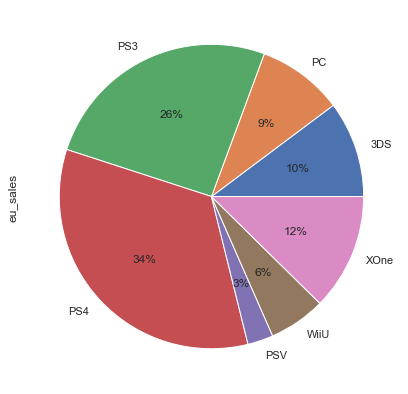

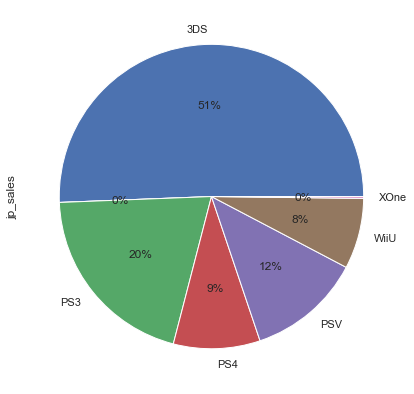

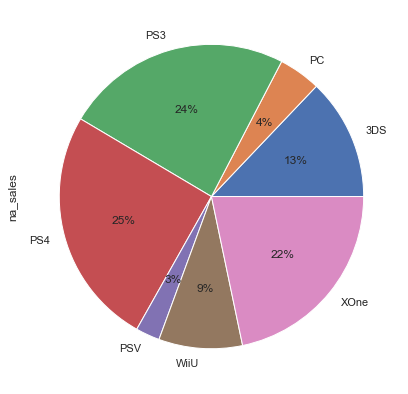

In [41]:
for i in platforms_sales.columns:
    platforms_sales[i].plot(kind='pie', figsize=(7,7),  autopct='%1.0f%%')
    plt.show()

<b> У пользователей Европы и Северной Америки схожие вкусы, но японские консоли в Европе немного преобладают. Консаоль Хbox - американская, поэтому в Америке это лидер на рынке. В Японии же монополия консолей от SONY и Nintendo, причем портативные консоли занимают довольно большой сегмент.

<b> Теперь распределение по жанрам:

In [42]:
genre_sales = pd.pivot_table(actual_data, index='genre', 
               values=['na_sales', 'eu_sales', 'jp_sales'], 
               aggfunc='sum')
genre_sales

,eu_sales,jp_sales,na_sales
genre,,,
Action,126.88,48.21,125.44
Adventure,8.23,6.52,6.95
Fighting,9.58,8.92,16.60
Misc,15.63,11.31,19.62
Platform,19.44,8.63,22.72
Puzzle,1.31,1.48,1.13
Racing,23.01,2.44,13.91
Role-Playing,43.97,57.92,54.59
Shooter,92.18,8.71,100.07


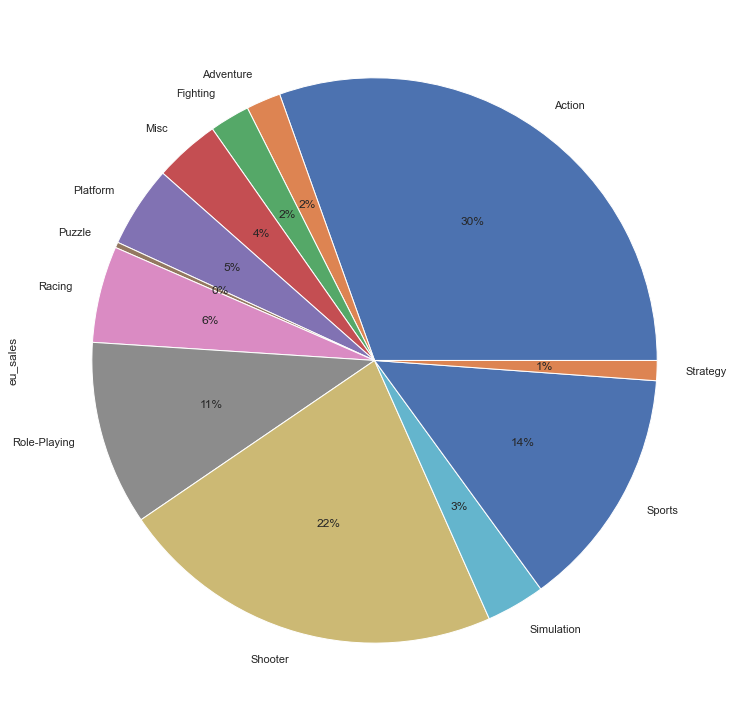

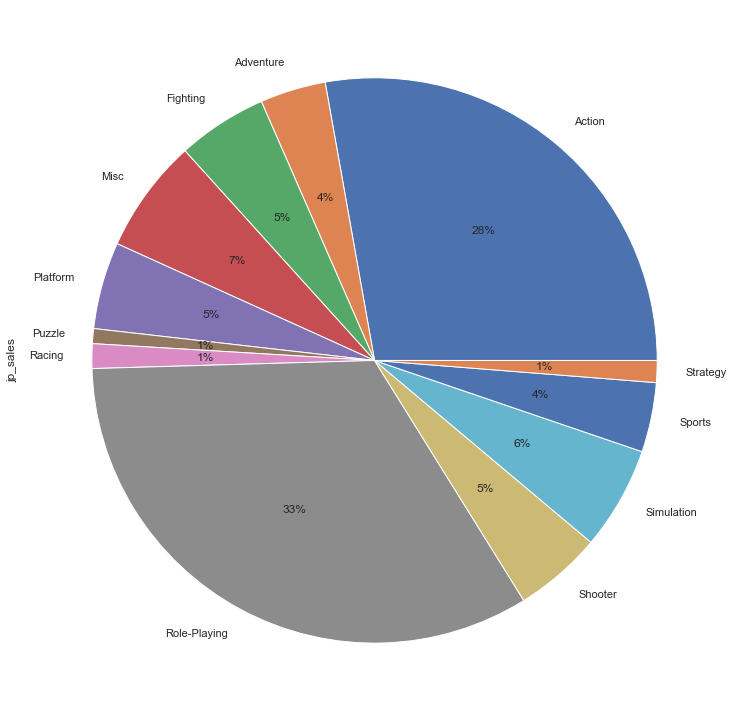

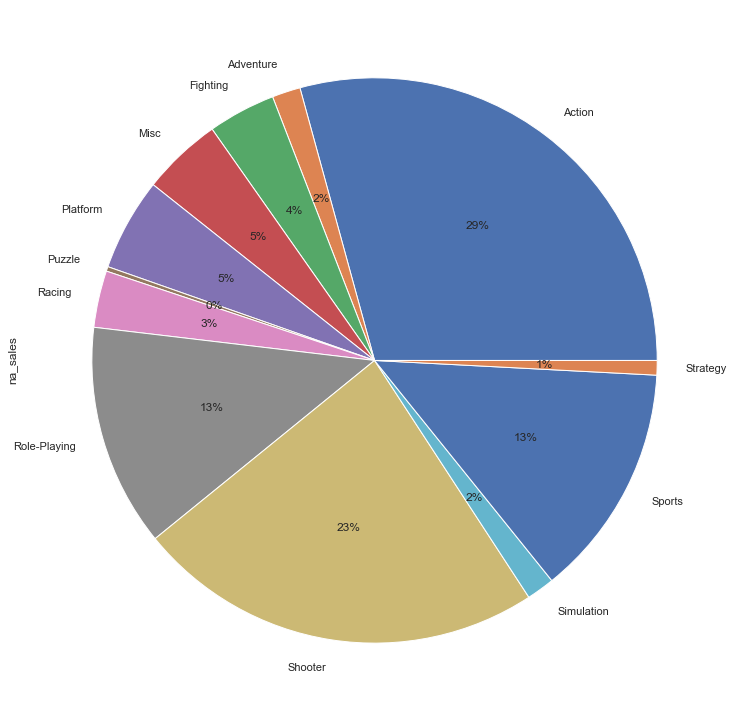

In [43]:
for i in genre_sales.columns:
    genre_sales[i].plot(kind='pie', figsize=(13,13),  autopct='%1.0f%%')
    plt.show()

<b> В Европе и Америке картины опять схожи, в Японии меньше шутеры любят меньше, но доля РПГ-игр, симуляторов и платформеров куда выше.

<b>Теперь проверим, влияет ли жанр на продажи в каждом регионе:

In [44]:
rating_reg = pd.pivot_table(actual_data, index='rating', 
               values=['na_sales', 'eu_sales', 'jp_sales'],
               aggfunc='sum')

rating_reg['eu_sales_pr'] = (rating_reg['eu_sales'] / 
                             rating_reg['eu_sales'].sum()) * 100

rating_reg['jp_sales_pr'] = (rating_reg['jp_sales'] / 
                             rating_reg['jp_sales'].sum()) * 100

rating_reg['na_sales_pr'] = (rating_reg['na_sales'] / 
                             rating_reg['na_sales'].sum()) * 100

(rating_reg
.style
.format({'eu_sales_pr': '{:.2f}%', 
         'na_sales_pr': '{:.2f}%',
         'jp_sales_pr': '{:.2f}%',
         'eu_sales': '{:.2f}',
         'jp_sales': '{:.2f}',
         'na_sales': '{:.2f}'})
)

,eu_sales,jp_sales,na_sales,eu_sales_pr,jp_sales_pr,na_sales_pr
rating,,,,,,
E,94.67,26.75,86.67,22.72%,15.42%,20.21%
E10+,38.65,7.85,47.79,9.28%,4.53%,11.14%
M,156.56,20.12,157.23,37.57%,11.60%,36.67%
T,45.65,25.48,51.94,10.96%,14.69%,12.11%
no_rating,81.15,93.23,85.18,19.48%,53.76%,19.86%


<b> В Америке и Европе проценты схожи, в Японии больше любят игры с T рейтингом и меньше - с рейтингом М, также в Японии больше половины игр без рейтинга, возможно, там мягче законы в отношении насилия в играх или рейтинг не обязателен. В Европе и Америке каждая пятая игра тоже не имеет рейтинга, или же данных о нём нет.

### Проверка гипотез.

<b> Первая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Н1: Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [45]:
XOne_user = actual_data.query('platform == "XOne"').user_score   
PC_user = actual_data.query('platform == "PC"').user_score                
print('Средний пользовательский рейтинг платформы Xbox One:', XOne_user.mean())
print('Средний пользовательский рейтинг платформы PC', PC_user.mean())


alpha = .05

results = st.ttest_ind(XOne_user, PC_user, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг платформы Xbox One: 6.512903233369191
Средний пользовательский рейтинг платформы PC 6.4403846277640415
p-значение: nan
Не получилось отвергнуть нулевую гипотезу


<b> Для оценки гипотезы мы применяли тест Стюдента (проверяется равенство средних значений в двух выборках), больших выбросов в значениях нет. Тест выявил, что нулевая гипотеза верна, следовательно, игры на Хbox One и PC нравятся пользователям примерно одинаково.

<b> Вторая гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

Н0: Средние пользовательские рейтинги жанров Action и Sports равны.

Н1: Средние пользовательские рейтинги жанров Action и Sports разные.

In [46]:
Action_user = actual_data.query('genre == "Action"').user_score   
Sports_user = actual_data.query('genre == "Sports"').user_score   
print('Средний пользовательский рейтинг жанра Action:', Action_user.mean())
print('Средний пользовательский рейтинг жанра Sports', Sports_user.mean())

alpha = .05

results = st.ttest_ind(Action_user, Sports_user, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг жанра Action: 6.87848972335833
Средний пользовательский рейтинг жанра Sports 5.525806446248485
p-значение: nan
Не получилось отвергнуть нулевую гипотезу


<b> Использовали тот же тест, нулевая гипотеза не верна, значит, рейтинги двух жанров не равны. Можно предположить, что спортивные игры разрабатываются для определенной целевой аудитории, которая гораздо критичнее относится к продукту.

### Общий вывод.

<b>В ходе выполнения проекта была проведена предобработка данных, далее был проведен анализ продаж за весь период, выявлен период, которые необходимо использовать для прогнозирования. Выявлены топ-платформы по продажам, влияние оценки критиков и пользователей на продажи и портрет геймера для каждого региона. Проверены две теории.

Продажи компьютерных больше всего зависят от платформы и жанра. На данный момент на рынке актуальны платформы Xbox One и PS4, игры на PC и DS3 будут покупать, но в меньших объёмах. Учитывая цикл разработки консолей, в новом году можно ожидать новые решения, но это не значит, что предыдущие поколения сразу станут неактуальными. В приоритете продажа игр в жанрах шутера и экшн, остальные жанры необходимо продвигать с учетом целевой аудитории. Для японского региона необходимо сделать упор на комплекс жанров (шутеры там менее популярны) и на игры для японских консолей, в том числе портативных. 

    
При выходе новой игры можно использовать данное исследование и спрогнозировать её успешность на рынке. Например, если это шутер с рейтингом 17+ на консоли, игра точно будет продаваться в Америке и Европе.